## _*Initializing next computation from prior result*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using VQE and TwoLocal. It is compared to the same energies as computed by the NumPyMinimumEigensolver and we also compare using the previous computed optimal solution as the starting initial point for the next distance.

This notebook has been written to use the PYQUANTE chemistry driver. See the PYQUANTE chemistry driver readme if you need to install the external PyQuante2 library that this driver requires.

## Introduction

In many applications it is important to find the minimum eigenvalue of a matrix. For example, in chemistry, the minimum eigenvalue of a Hermitian matrix characterizing the molecule is the ground state energy of that system. In the future, the quantum phase estimation algorithm may be used to find the minimum eigenvalue. However, its implementation on useful problems requires circuit depths exceeding the limits of hardware available in the NISQ era. Thus, in 2014, Peruzzo *et al.* proposed VQE to estimate the ground state energy of a molecule using much shallower circuits [1]. 

Formally stated, given a Hermitian matrix $H$ with an unknown minimum eigenvalue $\lambda_{\text{min}}$, associated with the eigenstate $|\psi_{\text{min}}\rangle$, VQE provides an estimate $\lambda_{\theta}$ bounding $\lambda_{\text{min}}$:

$$
\begin{aligned}
    \lambda_{\text{min}} \le \lambda_{\theta} \equiv \langle \psi(\theta) |H|\psi(\theta) \rangle
\end{aligned}  
$$

where $|\psi(\theta)\rangle$ is the eigenstate associated with $\lambda_{\theta}$. By applying a parameterized circuit, represented by $U(\theta)$, to some arbitrary starting state $|\psi\rangle$, the algorithm obtains an estimate $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle$ on $|\psi_{\text{min}}\rangle$. The estimate is iteratively optimized by a classical controller changing the parameter $\theta$ minimizing the expectation value of $\langle \psi(\theta) |H|\psi(\theta) \rangle$.



# Simulate the ground state of a Hydrogen molecule using Variational Quantum Eigensolver (VQE) on the Quantinuum emulator

![Hydrogen molecule](https://user-images.githubusercontent.com/4041805/166981145-c33b8d1a-24d1-4776-91ee-f514b0a5ab04.jpg)

In this notebook, you'll learn how to run VQE for a $H_{2}$ molecule on the Quantinuum emulator using Qiskit .

VQE is a variational algorithm for quantum chemistry that uses an optimization loop to minimize a cost function. The cost function is an energy evaluation $E = <\psi|H|\psi>$ where $|\psi (\theta)>$ is a parametric trial state that estimates the ground state of the molecule. For each evaluation, we modify the trial state until the energy reaches a minimum.

![VQE diagram](https://user-images.githubusercontent.com/4041805/166981008-023aba4c-26f8-498e-93ee-a1d9a39ddbcd.png)

For more information about running VQE using Qiskit, see: [Qiskit Textbook - VQE Molecules](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#implementationnoisy).

To read more about the optimization method used in this example, see [Wikipedia - SPSA](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation).

In [1]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.chemistry.drivers import PyQuanteDriver, BasisType
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

Couldn't find cython int routine
Couldn't find cython int routine


/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/visualization/circuit_visualization.py:699: UserWarning: Style JSON file 'iqp' not found. Will use default style.
  cregbundle=cregbundle, global_phase=global_phase)


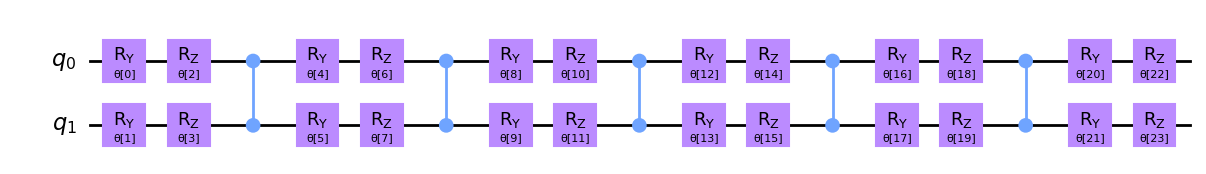

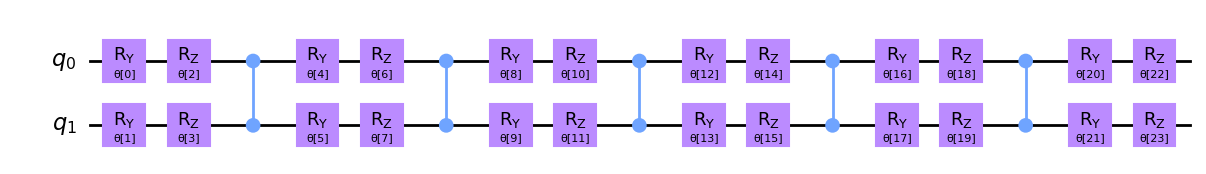

In [15]:
var_form.draw(output="mpl", idle_wires=False, style="iqp")

In [2]:
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
algorithms = [{'name': 'VQE'},
              {'name': 'VQE'},
              {'name': 'NumPyMinimumEigensolver'}]
titles= ['VQE Random Seed', 'VQE + Initial Point', 'NumPyMinimumEigensolver']

start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)
eval_counts = np.zeros([len(algorithms), steps+1], dtype=np.intp)

aqua_globals.random_seed = 50

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps
    for j in range(len(algorithms)):
        driver = PyQuanteDriver(molecule.format(d/2), basis=BasisType.BSTO3G)
        qmolecule = driver.run()
        operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY, two_qubit_reduction=True)
        qubit_op, aux_ops = operator.run(qmolecule)
        if algorithms[j]['name'] == 'NumPyMinimumEigensolver':
            result = NumPyMinimumEigensolver(qubit_op).run()
        else:
            optimizer = COBYLA(maxiter=10000)
            var_form = TwoLocal(qubit_op.num_qubits, ['ry', 'rz'], 'cz', reps=5, entanglement='linear')
            algo = VQE(qubit_op, var_form, optimizer)
            result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                seed_simulator=aqua_globals.random_seed,
                                seed_transpiler=aqua_globals.random_seed))
            eval_counts[j][i] = result.optimizer_evals
            if j == 1:
                algorithms[j]['initial_point'] = result.optimal_point.tolist()
        
        result = operator.process_algorithm_result(result)
        energies[j][i] = result.energy
        hf_energies[i] = result.hartree_fock_energy

    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)

Processing step __ 0

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/circuit/tools/pi_check.py:49: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-fr

 1

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

 2

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

 3

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

 4

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

 5

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

 6

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

 7

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

 8

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

 9

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

10

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

11

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

12

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

13

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

14

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

15

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

16

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

17

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

18

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

19

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

20

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is depre

 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[-1.05515974 -1.07591361 -1.09262988 -1.10591802 -1.11628598 -1.1241609
  -1.12990476 -1.13382621 -1.13618944 -1.13722136 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836189 -1.12467176 -1.12056029 -1.11609625
  -1.11133943 -1.10634212 -1.10115034]
 [-1.05515974 -1.07591361 -1.09262988 -1.10591802 -1.11628599 -1.1241609
  -1.12990476 -1.13382621 -1.13618944 -1.13722136 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836188 -1.12467176 -1.12056029 -1.11609625
  -1.11133943 -1.10634212 -1.10115034]
 [-1.05515975 -1.07591362 -1.09262988 -1.10591802 -1.11628599 -1.1241609
  -1.12990477 -1.13382621 -1.13618945 -1.13722136 -1.13711707 -1.13604437
  -1.13414767 -1.13155121 -1.12836189 -1.12467176 -1.12056029 -1.11609625
  -1.11133943 -1.10634212 -1.10115034]]
Hartree-Fock energies: [-1.04299623 -1.0630621  -1.079

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()


The plot of ground energies from VQE, whether starting from a random initial point or the optimal solution from the prior point are indistinguisable here.

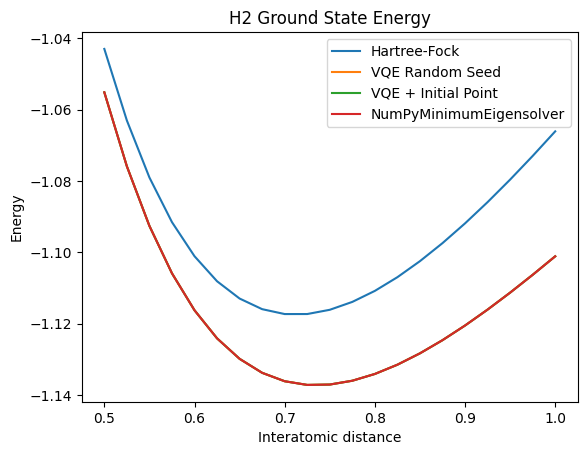

In [3]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=titles[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right');

/Users/xuy/.conda/envs/QC_PYQUANTE/lib/python3.7/site-packages/sympy/core/expr.py:2442: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  return {j for i in self.args for j in i.expr_free_symbols}


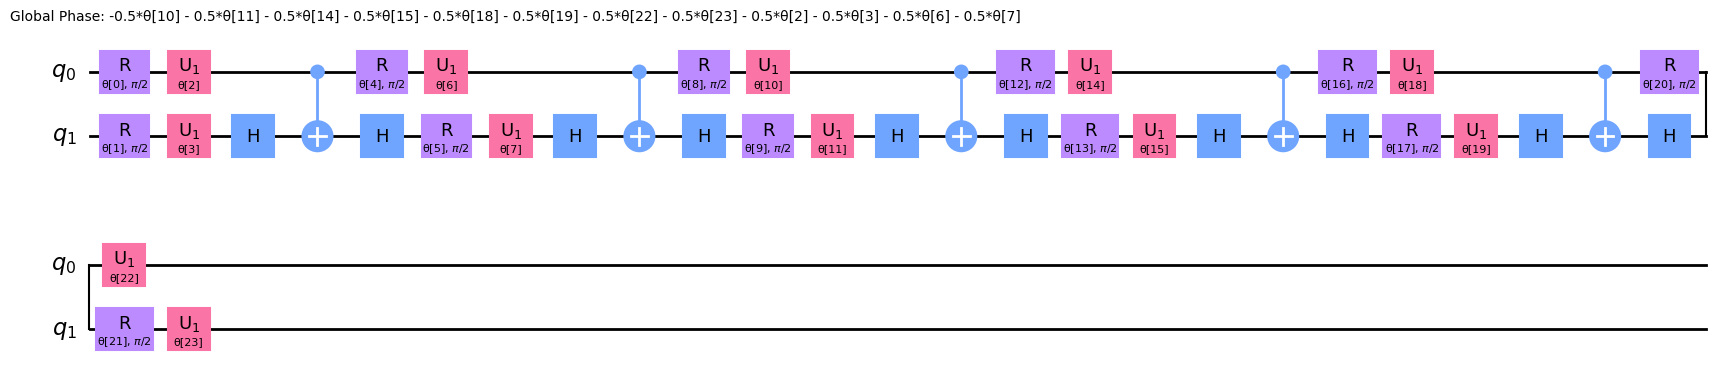

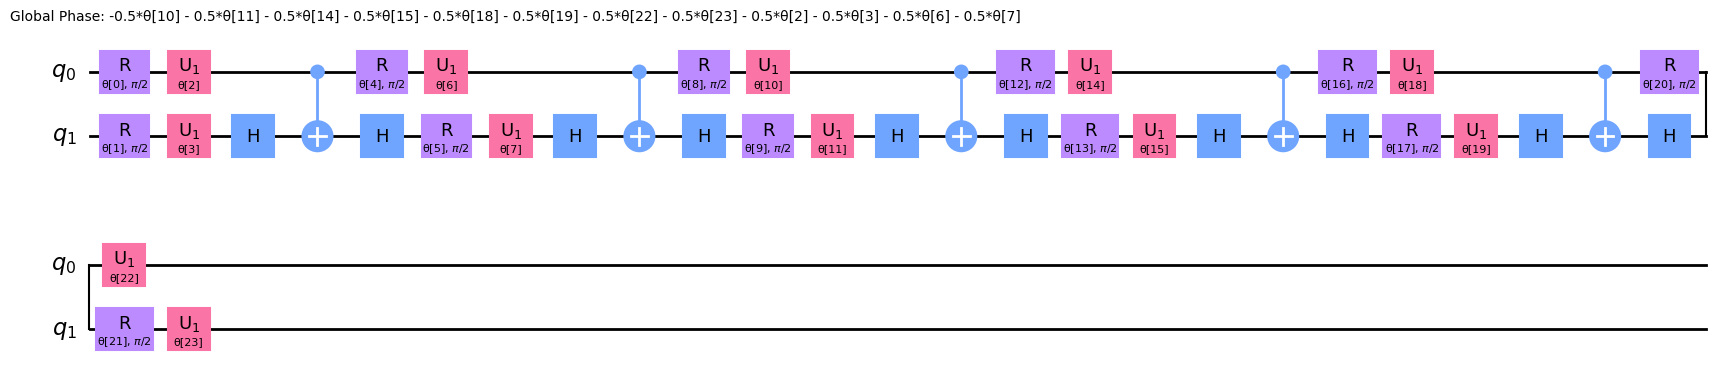

In [4]:
var_form.decompose().draw("mpl")

In [14]:
print('Qubit Operator:')
print(qubit_op)  # Prints the entire operator

print('Number of qubits:', qubit_op.num_qubits)  # Prints the number of qubits

print('Operator terms:')
for term in qubit_op.oplist:
    coeff, pauli = term
    print(f'Coefficient: {coeff}, Pauli string: {pauli}')

Qubit Operator:
Electronic Hamiltonian: Representation: paulis, qubits: 2, size: 5
Number of qubits: 2
Operator terms:


AttributeError: 'WeightedPauliOperator' object has no attribute 'oplist'

In [10]:
print(aux_ops)

[<qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator object at 0x7f904c143190>, <qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator object at 0x7f904c549dd0>, <qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator object at 0x7f904c15cc90>]


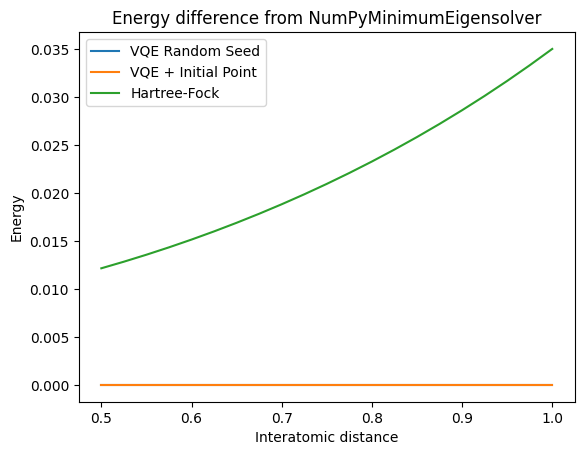

In [10]:
for i in range(2):
    pylab.plot(distances, np.subtract(energies[i], energies[2]), label=titles[i])
pylab.plot(distances, np.subtract(hf_energies, energies[2]), label='Hartree-Fock')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from NumPyMinimumEigensolver')
pylab.legend(loc='upper left');

Lets plot the difference of the VQE ground state energies from the NumPyMinimumEigensolver. They are both in the same ballpark and both very small.

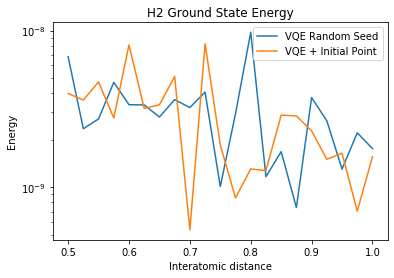

In [4]:
for i in range(len(algorithms)-1):
    pylab.plot(distances, np.subtract(energies[i], energies[2]), label=titles[i])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.yscale('log')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right');

Finally lets plot the number of evaluations taken at each point. Both start out at the same number since we start them the same. But we can see, as we step along small distances, that the prior solution is a better guess as the starting point for the next step leading to fewer evaluations.

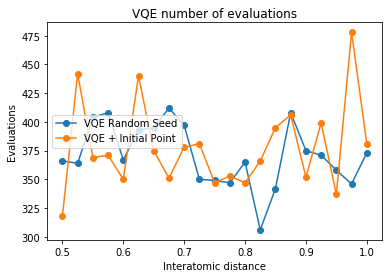

In [5]:
for i in range(2):
    pylab.plot(distances, eval_counts[i], '-o', label=titles[i])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Evaluations')
pylab.title('VQE number of evaluations')
pylab.legend(loc='center left');

In [6]:
for i in range(2):
    print("Total evaluations for '{}' = {}".format(titles[i], np.sum(eval_counts[i])))

percent = np.sum(eval_counts[1])*100/np.sum(eval_counts[0])
print("\nTotal evaluations for '{}' are {:.2f}% of '{}'".format(titles[1], percent, titles[0]))

Total evaluations for 'VQE Random Seed' = 7796
Total evaluations for 'VQE + Initial Point' = 7936

Total evaluations for 'VQE + Initial Point' are 101.80% of 'VQE Random Seed'
